<a target="_blank" href="https://colab.research.google.com/github/Nicolepcx/CFEM-Seminar/blob/main/Chat_with_data.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
!pip install python-dotenv langgraph langchain_experimental langchain_openai -qqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.7/412.7 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from IPython.display import Image, display
from typing import List, Literal, Optional, TypedDict, Annotated
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage
from langchain_experimental.utilities import PythonREPL
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
import os
from dotenv import load_dotenv
load_dotenv()


True

In [ ]:
NEBIUS_API_KEY = os.getenv("NEBIUS_API_KEY")

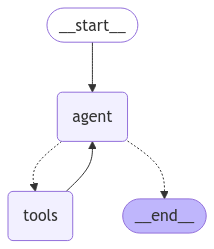

In [ ]:

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

@tool
def python_repl(code: Annotated[str, "filename to read the code from"]):
    """Use this to execute python code read from a file. If you want to see the output of a value,
    Make sure that you read the code from correctly
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = PythonREPL().run(code)
        print("RESULT CODE EXECUTION:", result)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Executed:\n```python\n{code}\n```\nStdout: {result}"


llm_with_tools = llm.bind_tools([python_repl])

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("agent", chatbot)

code_execution = ToolNode(tools=[python_repl])

graph_builder.add_node("tools", code_execution)

def route_tools(state: State):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

graph_builder.add_edge(START, "agent")
graph_builder.add_conditional_edges(
    "agent",
    route_tools,
    {"tools": "tools", END: END},
)
graph_builder.add_edge("tools", "agent")

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))


User: print the first 5 rows of /content/loans_payments.csv
================================ Human Message =================================

print the first 5 rows of /content/loans_payments.csv


================================== Ai Message ==================================
Tool Calls:
  python_repl (call_KjmfkttLMU8vvLCq0t9kSGUf)
 Call ID: call_KjmfkttLMU8vvLCq0t9kSGUf
  Args:
    code: import pandas as pd

# Load the CSV file
file_path = '/content/loans_payments.csv'
df = pd.read_csv(file_path)

# Display the first 5 rows
print(df.head())
RESULT CODE EXECUTION:        Loan_ID loan_status  Principal  terms effective_date   due_date  \
0  xqd20166231     PAIDOFF       1000     30       9/8/2016  10/7/2016   
1  xqd20168902     PAIDOFF       1000     30       9/8/2016  10/7/2016   
2  xqd20160003     PAIDOFF       1000     30       9/8/2016  10/7/2016   
3  xqd20160004     PAIDOFF       1000     15       9/8/2016  9/22/2016   
4  xqd20160005     PAIDOFF       1000     30       9/9/2016  10/8/2016   

     paid_off_time  past_due_days  age             education  Gender  
0  9/14/2016 19:31            NaN   45  High School or Below    male  
1   10/7/2016 9:00            NaN   5

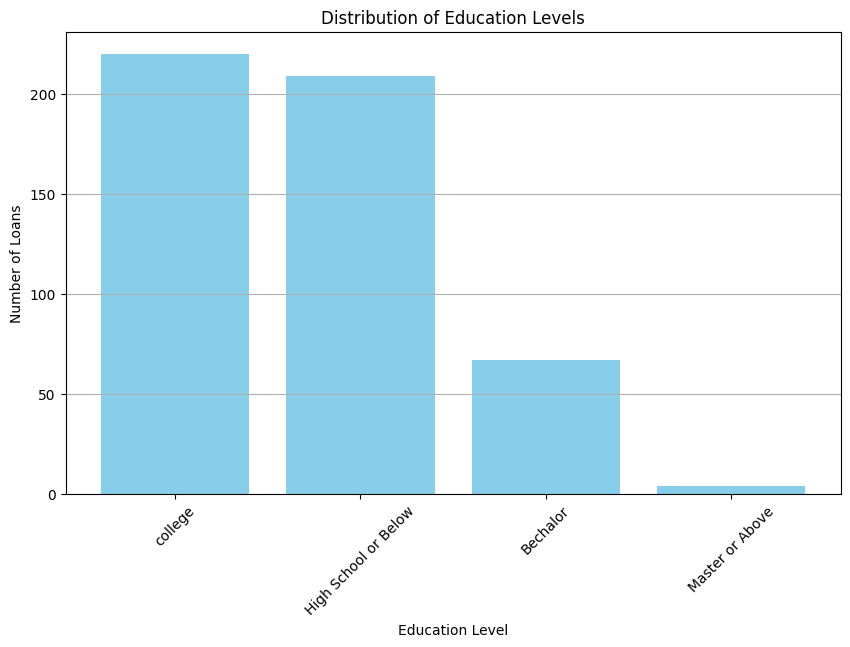

RESULT CODE EXECUTION: 
================================= Tool Message =================================
Name: python_repl

Executed:
```python
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = '/content/loans_payments.csv'
df = pd.read_csv(file_path)

# Count the occurrences of each education level
education_counts = df['education'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(education_counts.index, education_counts.values, color='skyblue')
plt.title('Distribution of Education Levels')
plt.xlabel('Education Level')
plt.ylabel('Number of Loans')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()
```
Stdout: 
================================== Ai Message ==================================

The bar chart displaying the distribution of education levels among the loans has been plotted successfully. However, I cannot display the chart directly here. You can run the provided code in your local environment to visualize th

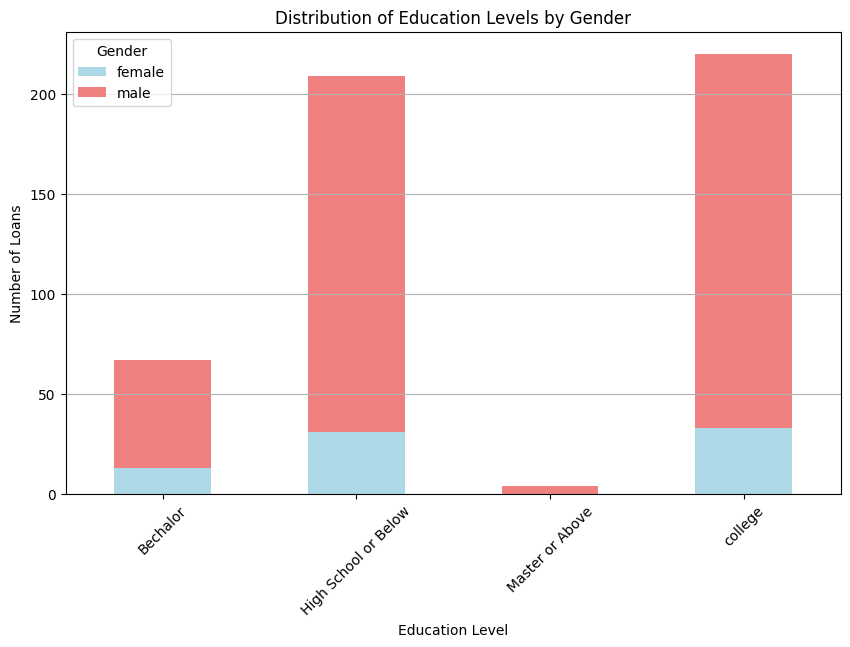

RESULT CODE EXECUTION: 
================================= Tool Message =================================
Name: python_repl

Executed:
```python
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = '/content/loans_payments.csv'
df = pd.read_csv(file_path)

# Create a cross-tabulation of gender and education
gender_education_counts = pd.crosstab(df['education'], df['Gender'])

# Plotting the bar chart
gender_education_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightblue', 'lightcoral'])
plt.title('Distribution of Education Levels by Gender')
plt.xlabel('Education Level')
plt.ylabel('Number of Loans')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.grid(axis='y')
plt.show()
```
Stdout: 
================================== Ai Message ==================================

The bar chart showing the distribution of education levels by gender has been plotted successfully. However, I cannot display the chart directly here. You can run the

In [ ]:
config = {"configurable": {"thread_id": "1"}}

def stream_graph_updates(user_input: str):
    events = graph.stream(
        {"messages": [("user", user_input)]}, config, stream_mode="values"
    )
    for event in events:
        event["messages"][-1].pretty_print()

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    stream_graph_updates(user_input)


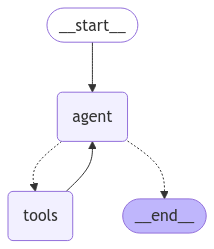

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(
                model="meta-llama/Llama-3.3-70B-Instruct-fast",
                temperature=0,
                max_tokens=None,
                timeout=None,
                max_retries=2,
                api_key=NEBIUS_API_KEY,
                base_url="https://api.studio.nebius.ai/v1/"
            )

@tool
def python_repl(code: Annotated[str, "filename to read the code from"]):
    """Use this to execute python code read from a file. If you want to see the output of a value,
    Make sure that you read the code from correctly
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = PythonREPL().run(code)
        print("RESULT CODE EXECUTION:", result)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Executed:\n```python\n{code}\n```\nStdout: {result}"


llm_with_tools = llm.bind_tools([python_repl])

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("agent", chatbot)

code_execution = ToolNode(tools=[python_repl])

graph_builder.add_node("tools", code_execution)

def route_tools(state: State):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

graph_builder.add_edge(START, "agent")
graph_builder.add_conditional_edges(
    "agent",
    route_tools,
    {"tools": "tools", END: END},
)
graph_builder.add_edge("tools", "agent")

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))


User: print the first 5 rows of /content/loans_payments.csv
================================ Human Message =================================

print the first 5 rows of /content/loans_payments.csv
================================== Ai Message ==================================
Tool Calls:
  python_repl (chatcmpl-tool-93e5cfffc6fa4aa8873092051bd5c3ab)
 Call ID: chatcmpl-tool-93e5cfffc6fa4aa8873092051bd5c3ab
  Args:
    code: import pandas as pd
print(pd.read_csv("/content/loans_payments.csv").head(5))
RESULT CODE EXECUTION:        Loan_ID loan_status  Principal  terms effective_date   due_date  \
0  xqd20166231     PAIDOFF       1000     30       9/8/2016  10/7/2016   
1  xqd20168902     PAIDOFF       1000     30       9/8/2016  10/7/2016   
2  xqd20160003     PAIDOFF       1000     30       9/8/2016  10/7/2016   
3  xqd20160004     PAIDOFF       1000     15       9/8/2016  9/22/2016   
4  xqd20160005     PAIDOFF       1000     30       9/9/2016  10/8/2016   

     paid_off_time  past_du

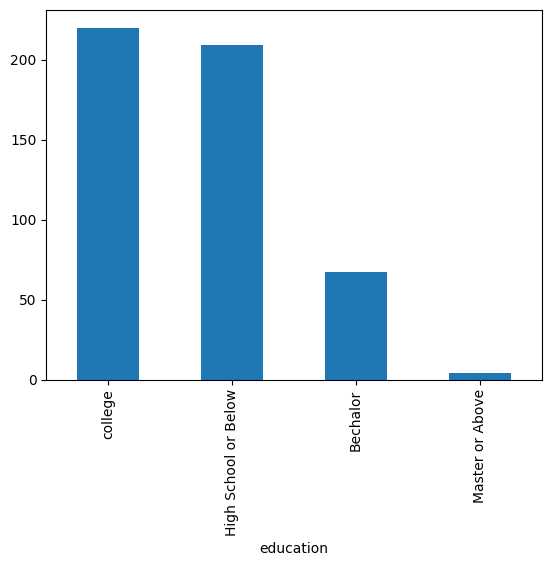

RESULT CODE EXECUTION: 
================================= Tool Message =================================
Name: python_repl

Executed:
```python
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("/content/loans_payments.csv")
df['education'].value_counts().plot(kind='bar')
plt.show()
```
Stdout: 
================================== Ai Message ==================================

The function call with its proper arguments that best answers the given prompt is to execute a python script that reads the `/content/loans_payments.csv` file, counts the unique values in the 'education' column, and plots a bar chart of the counts. The python script uses the pandas library to read the csv file and the matplotlib library to create the bar chart.
User: plot a barchart of gender and education
================================ Human Message =================================

plot a barchart of gender and education


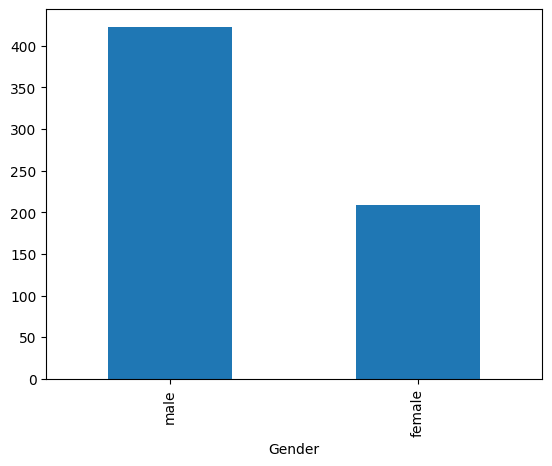

================================== Ai Message ==================================
Tool Calls:
  python_repl (chatcmpl-tool-c51bbcd3ee404e639a66071b6cf6393d)
 Call ID: chatcmpl-tool-c51bbcd3ee404e639a66071b6cf6393d
  Args:
    code: import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("/content/loans_payments.csv")
df['education'].value_counts().plot(kind='bar')
df['Gender'].value_counts().plot(kind='bar')
plt.show()
RESULT CODE EXECUTION: 
================================= Tool Message =================================
Name: python_repl

Executed:
```python
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("/content/loans_payments.csv")
df['education'].value_counts().plot(kind='bar')
df['Gender'].value_counts().plot(kind='bar')
plt.show()
```
Stdout: 
================================== Ai Message ==================================

The function call with its proper arguments that best answers the given prompt is to execute a python script that reads th

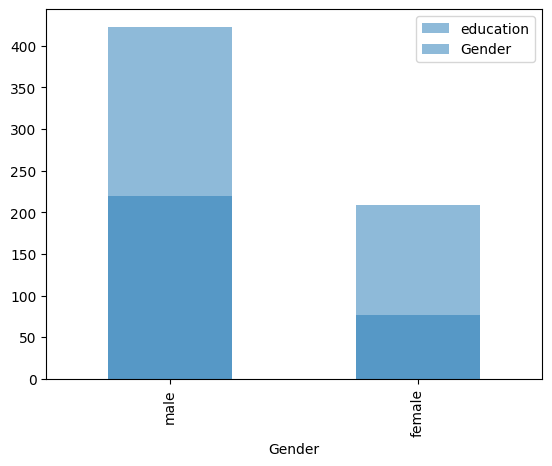

================================== Ai Message ==================================
Tool Calls:
  python_repl (chatcmpl-tool-820cedd6e5414e529c978efbd76ca38b)
 Call ID: chatcmpl-tool-820cedd6e5414e529c978efbd76ca38b
  Args:
    code: import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("/content/loans_payments.csv")
df['education'].value_counts().plot(kind='bar', alpha=0.5, label='education')
df['Gender'].value_counts().plot(kind='bar', alpha=0.5, label='Gender')
plt.legend()
plt.show()
RESULT CODE EXECUTION: 
================================= Tool Message =================================
Name: python_repl

Executed:
```python
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("/content/loans_payments.csv")
df['education'].value_counts().plot(kind='bar', alpha=0.5, label='education')
df['Gender'].value_counts().plot(kind='bar', alpha=0.5, label='Gender')
plt.legend()
plt.show()
```
Stdout: 
================================== Ai Message ==================

In [ ]:
config = {"configurable": {"thread_id": "1"}}

def stream_graph_updates(user_input: str):
    events = graph.stream(
        {"messages": [("user", user_input)]}, config, stream_mode="values"
    )
    for event in events:
        event["messages"][-1].pretty_print()

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    stream_graph_updates(user_input)
